In [123]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wildbluedata/WildBlueberryPollinationSimulationData.csv


# <span style="font-family:cursive;text-align:center"> Import Libraries</span>

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from scipy import stats
import shap

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold

## model hyperparameter tuning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import joblib

In [125]:
# Import data 
df = pd.read_csv("/kaggle/input/wildbluedata/WildBlueberryPollinationSimulationData.csv")

#### Features and their description  

| Features | Unit | Description |
| :------ | :-- | :--------- |
Clonesize | m2 | The average blueberry clone size in the field
Honeybee | bees/m2/min | Honeybee density in the field
Bumbles | bees/m2/min |Bumblebee density in the field
Andrena | bees/m2/min | Andrena bee density in the field
Osmia | bees/m2/min | Osmia bee density in the field
MaxOfUpperTRange | ℃ | The highest record of the upper band daily air temperature during the bloom season
MinOfUpperTRange | ℃ | The lowest record of the upper band daily air temperature
AverageOfUpperTRange | ℃ | The average of the upper band daily air temperature
MaxOfLowerTRange | ℃ |The highest record of the lower band daily air temperature
MinOfLowerTRange | ℃ | The lowest record of the lower band daily air temperature
AverageOfLowerTRange | ℃ | The average of the lower band daily air temperature
RainingDays | Day | The total number of days during the bloom season, each of which has precipitation larger than zero
AverageRainingDays | Day | The average of raining days of the entire bloom season

In [126]:
# first 5 row 
df.head()

,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.410652,0.408159,31.678898,3813.165795
1,1,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,1.0,0.10,0.444254,0.425458,33.449385,4947.605663
2,2,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,16.0,0.26,0.383787,0.399172,30.546306,3866.798965
3,3,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.407564,0.408789,31.562586,4303.943030
4,4,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.354413,0.382703,28.873714,3436.493543


In [127]:
# last 5 row 
df.tail()

,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
772,772,10.0,0.537,0.117,0.409,0.058,86.0,52.0,71.9,62.0,30.0,50.8,3.77,0.06,0.486815,0.428012,33.447471,5333.873335
773,773,40.0,0.537,0.117,0.409,0.058,86.0,52.0,71.9,62.0,30.0,50.8,3.77,0.06,0.342841,0.377915,28.462005,3373.436842
774,774,20.0,0.537,0.117,0.409,0.058,86.0,52.0,71.9,62.0,30.0,50.8,24.00,0.39,0.404617,0.401670,30.748240,4203.027624
775,775,20.0,0.537,0.117,0.409,0.058,89.0,39.0,65.6,66.0,28.0,45.3,3.77,0.06,0.401538,0.399935,30.582161,4166.299735
776,776,20.0,0.537,0.117,0.409,0.058,89.0,39.0,65.6,66.0,28.0,45.3,24.00,0.39,0.384646,0.392303,29.742583,3943.131681


In [128]:
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])

Rows: 777
Columns: 18


# <span style="font-family:cursive;text-align:center">⬇️ Data Preprocessing</span>

In [129]:
df.isnull().sum()

Row#                    0
clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

No null value in dataset

In [130]:
# statistics representation of data 
df.describe()

,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000
mean,388.000000,18.767696,0.417133,0.282389,0.468817,0.562062,82.277091,49.700515,68.723037,59.309395,28.690219,48.613127,18.309292,0.320000,0.502121,0.445983,36.122432,6012.849165
std,224.444871,6.999063,0.978904,0.066343,0.161052,0.169119,9.193745,5.595769,7.676984,6.647760,3.209547,5.417072,12.124226,0.171279,0.079445,0.040333,4.377889,1356.955318
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.192732,0.311921,22.079199,1637.704022
25%,194.000000,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,3.770000,0.100000,0.454725,0.416281,33.116091,5124.854901
50%,388.000000,12.500000,0.250000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.508297,0.445587,36.166044,6107.382466
75%,582.000000,25.000000,0.500000,0.380000,0.630000,0.750000,89.000000,52.000000,71.900000,66.000000,30.000000,50.800000,24.000000,0.390000,0.561297,0.476149,39.239668,7022.189731
max,776.000000,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.585105,8969.401842


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Row#                  777 non-null    int64  
 1   clonesize             777 non-null    float64
 2   honeybee              777 non-null    float64
 3   bumbles               777 non-null    float64
 4   andrena               777 non-null    float64
 5   osmia                 777 non-null    float64
 6   MaxOfUpperTRange      777 non-null    float64
 7   MinOfUpperTRange      777 non-null    float64
 8   AverageOfUpperTRange  777 non-null    float64
 9   MaxOfLowerTRange      777 non-null    float64
 10  MinOfLowerTRange      777 non-null    float64
 11  AverageOfLowerTRange  777 non-null    float64
 12  RainingDays           777 non-null    float64
 13  AverageRainingDays    777 non-null    float64
 14  fruitset              777 non-null    float64
 15  fruitmass             7

In [132]:
# Unique  attribute in each feature
df.nunique()

Row#                    777
clonesize                 6
honeybee                  7
bumbles                  10
andrena                  12
osmia                    12
MaxOfUpperTRange          5
MinOfUpperTRange          5
AverageOfUpperTRange      5
MaxOfLowerTRange          5
MinOfLowerTRange          5
AverageOfLowerTRange      5
RainingDays               5
AverageRainingDays        5
fruitset                777
fruitmass               777
seeds                   777
yield                   777
dtype: int64

# 📊 Exploratory Data Analysis

{'whiskers': [<matplotlib.lines.Line2D at 0x79ef7bc37d60>,
 'caps': [<matplotlib.lines.Line2D at 0x79ef7bc682e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x79ef7bc37b20>],
 'medians': [<matplotlib.lines.Line2D at 0x79ef7bc68820>],
 'fliers': [<matplotlib.lines.Line2D at 0x79ef7bc68ac0>],
 'means': []}

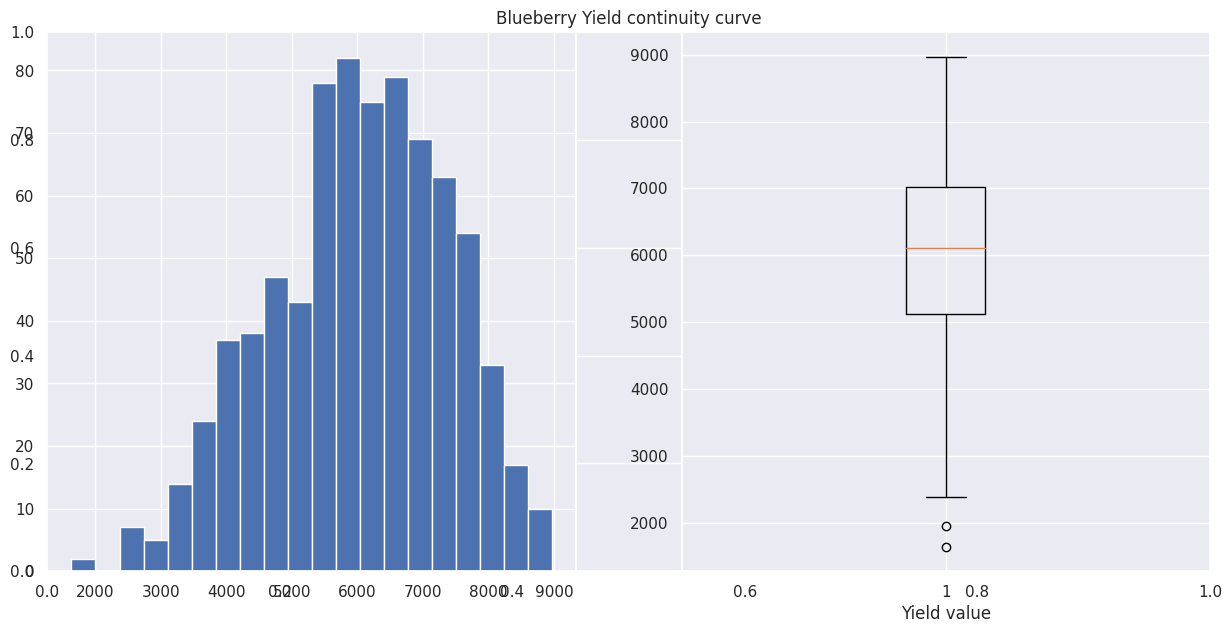

In [133]:
fig = plt.figure(figsize=(15,7))
plt.title("Blueberry Yield continuity curve")
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
x = df["yield"]
plt.xlabel("Yield value")
ax1.hist(x, bins=20)
ax2.boxplot(x)

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>]], dtype=object)

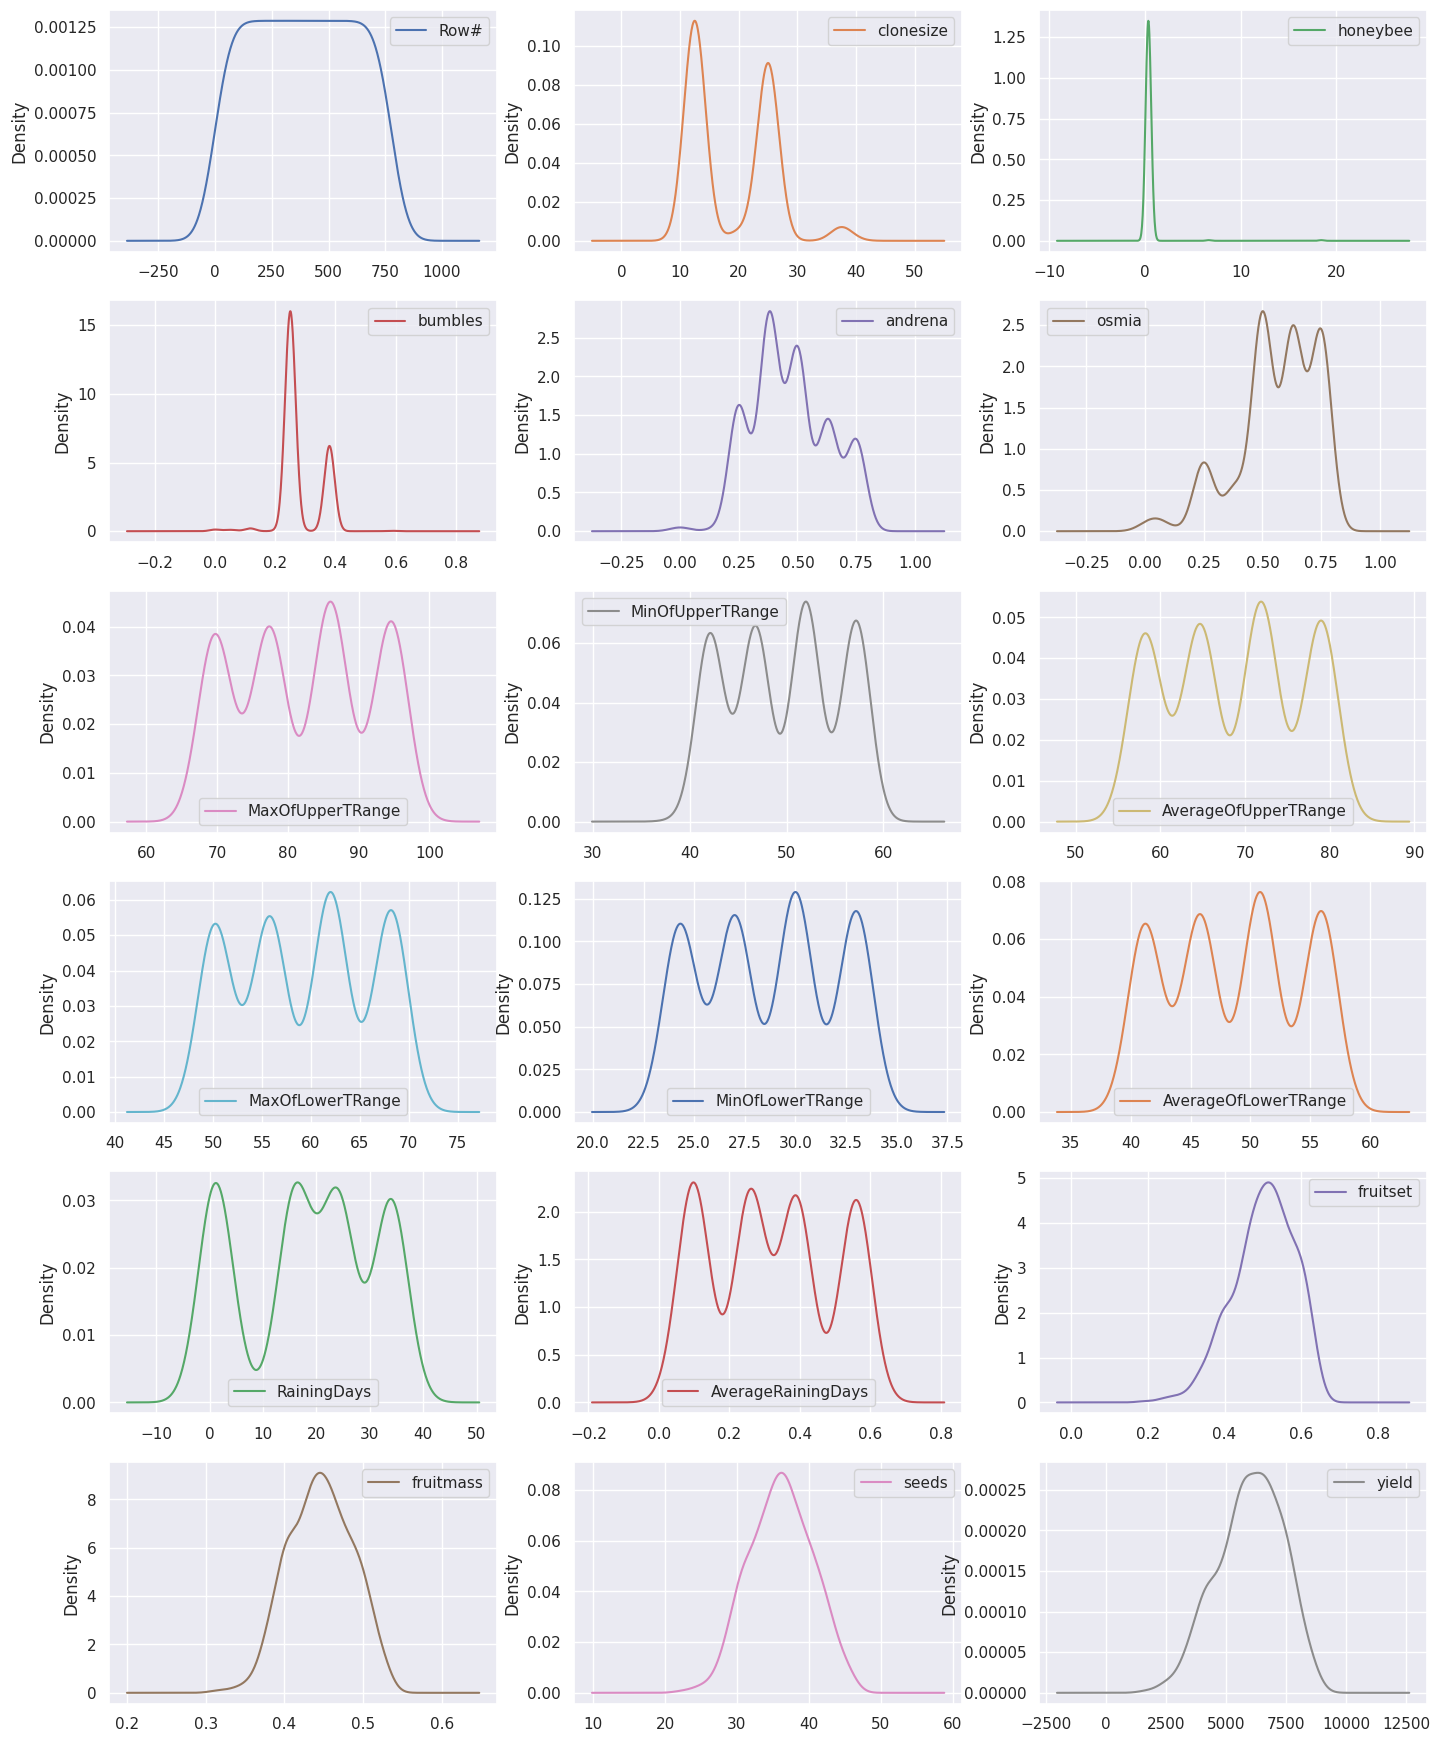

In [134]:
df.plot(kind="density", 
       subplots=True, 
       layout = (6, 3), 
       figsize = (17,22), 
       sharex=False, 
       sharey =False)

Row#                        Axes(0.125,0.77;0.227941x0.11)
clonesize                Axes(0.398529,0.77;0.227941x0.11)
honeybee                 Axes(0.672059,0.77;0.227941x0.11)
bumbles                    Axes(0.125,0.638;0.227941x0.11)
andrena                 Axes(0.398529,0.638;0.227941x0.11)
osmia                   Axes(0.672059,0.638;0.227941x0.11)
MaxOfUpperTRange           Axes(0.125,0.506;0.227941x0.11)
MinOfUpperTRange        Axes(0.398529,0.506;0.227941x0.11)
AverageOfUpperTRange    Axes(0.672059,0.506;0.227941x0.11)
MaxOfLowerTRange           Axes(0.125,0.374;0.227941x0.11)
MinOfLowerTRange        Axes(0.398529,0.374;0.227941x0.11)
AverageOfLowerTRange    Axes(0.672059,0.374;0.227941x0.11)
RainingDays                Axes(0.125,0.242;0.227941x0.11)
AverageRainingDays      Axes(0.398529,0.242;0.227941x0.11)
fruitset                Axes(0.672059,0.242;0.227941x0.11)
fruitmass                   Axes(0.125,0.11;0.227941x0.11)
seeds                    Axes(0.398529,0.11;0.227941x0.1

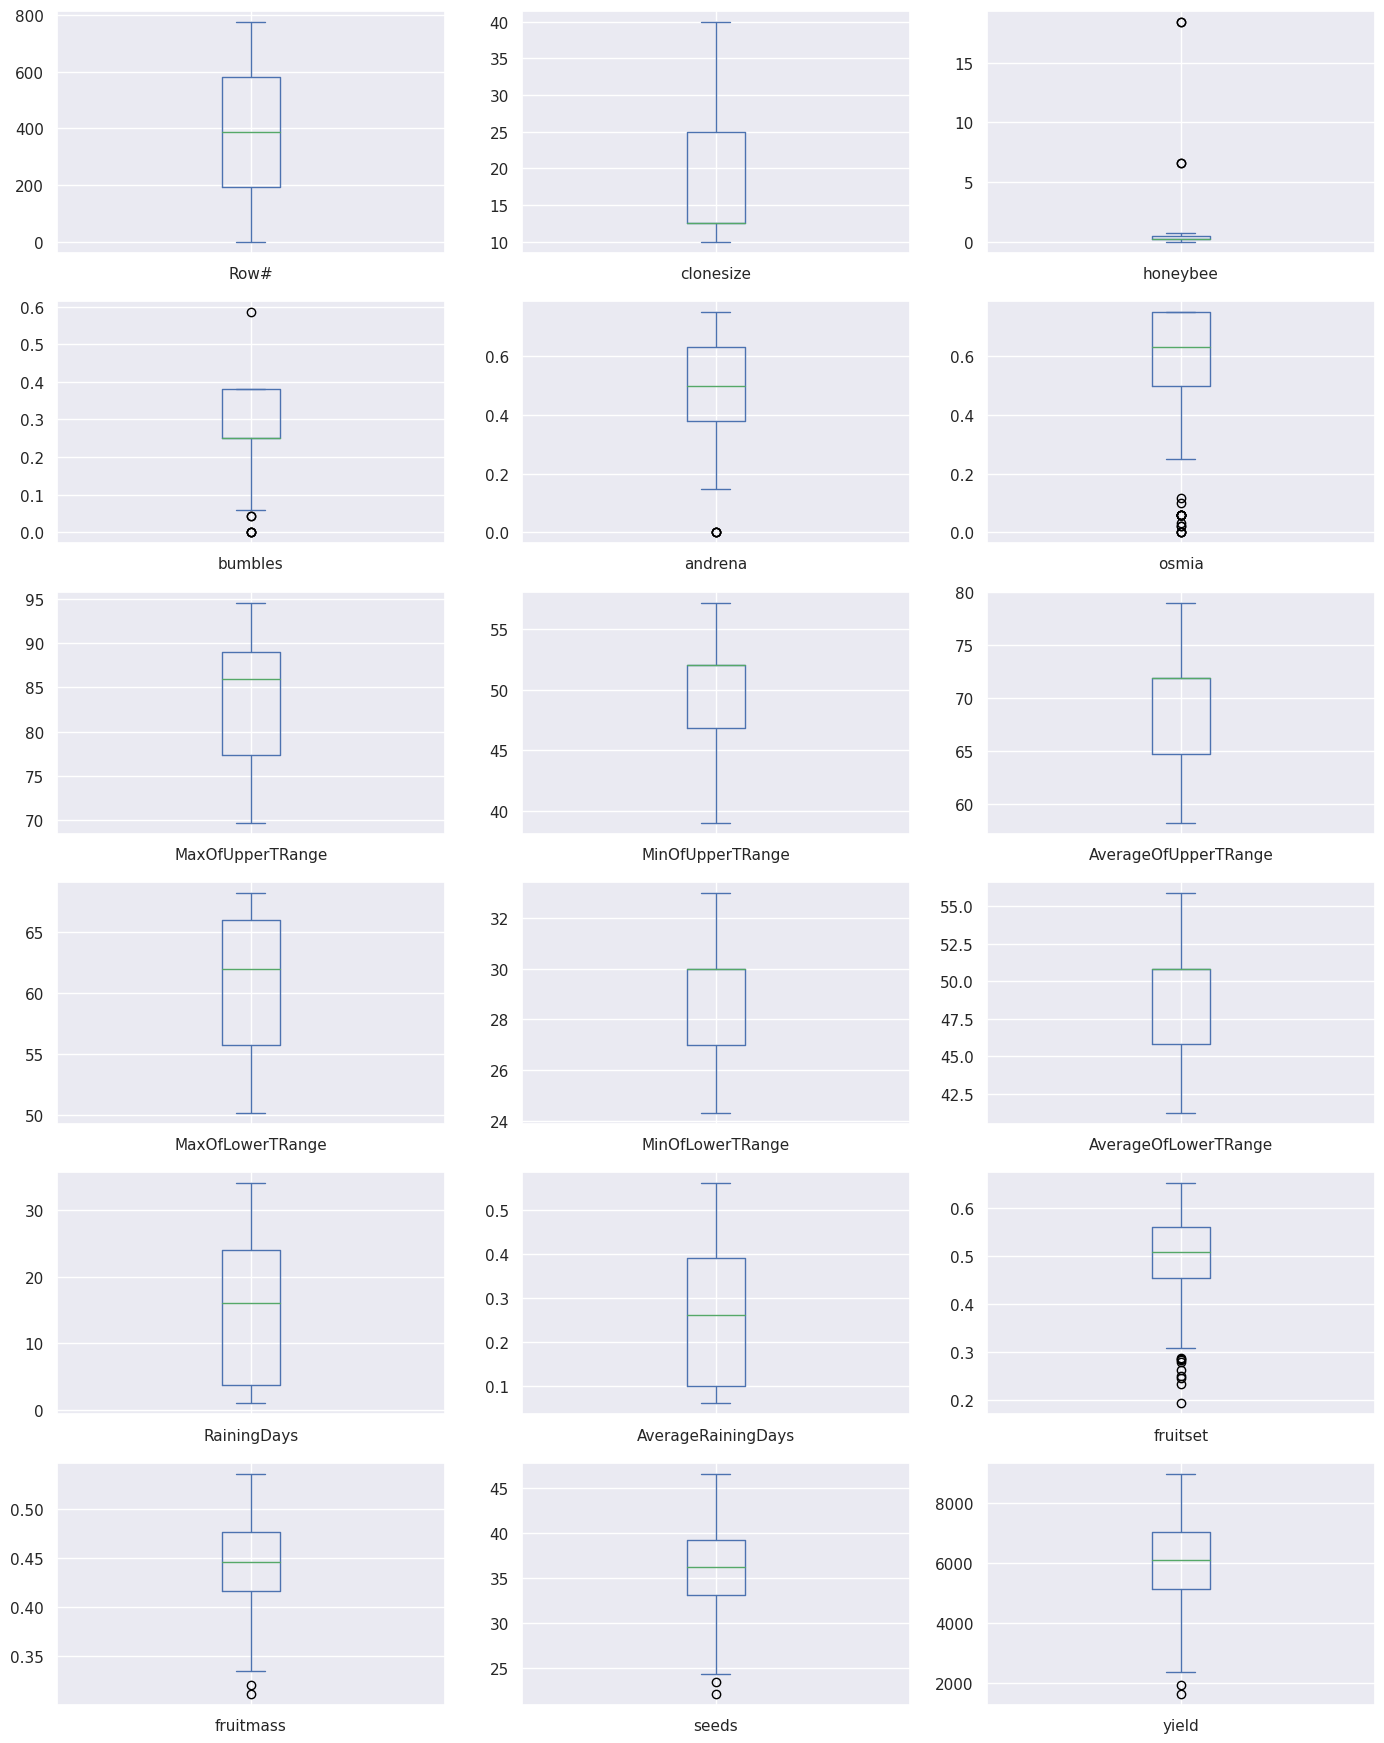

In [135]:
df.plot(kind="box", 
       subplots=True, 
       layout = (6, 3), 
       figsize = (17,22), 
       sharex=False, 
       sharey =False)

<Axes: >

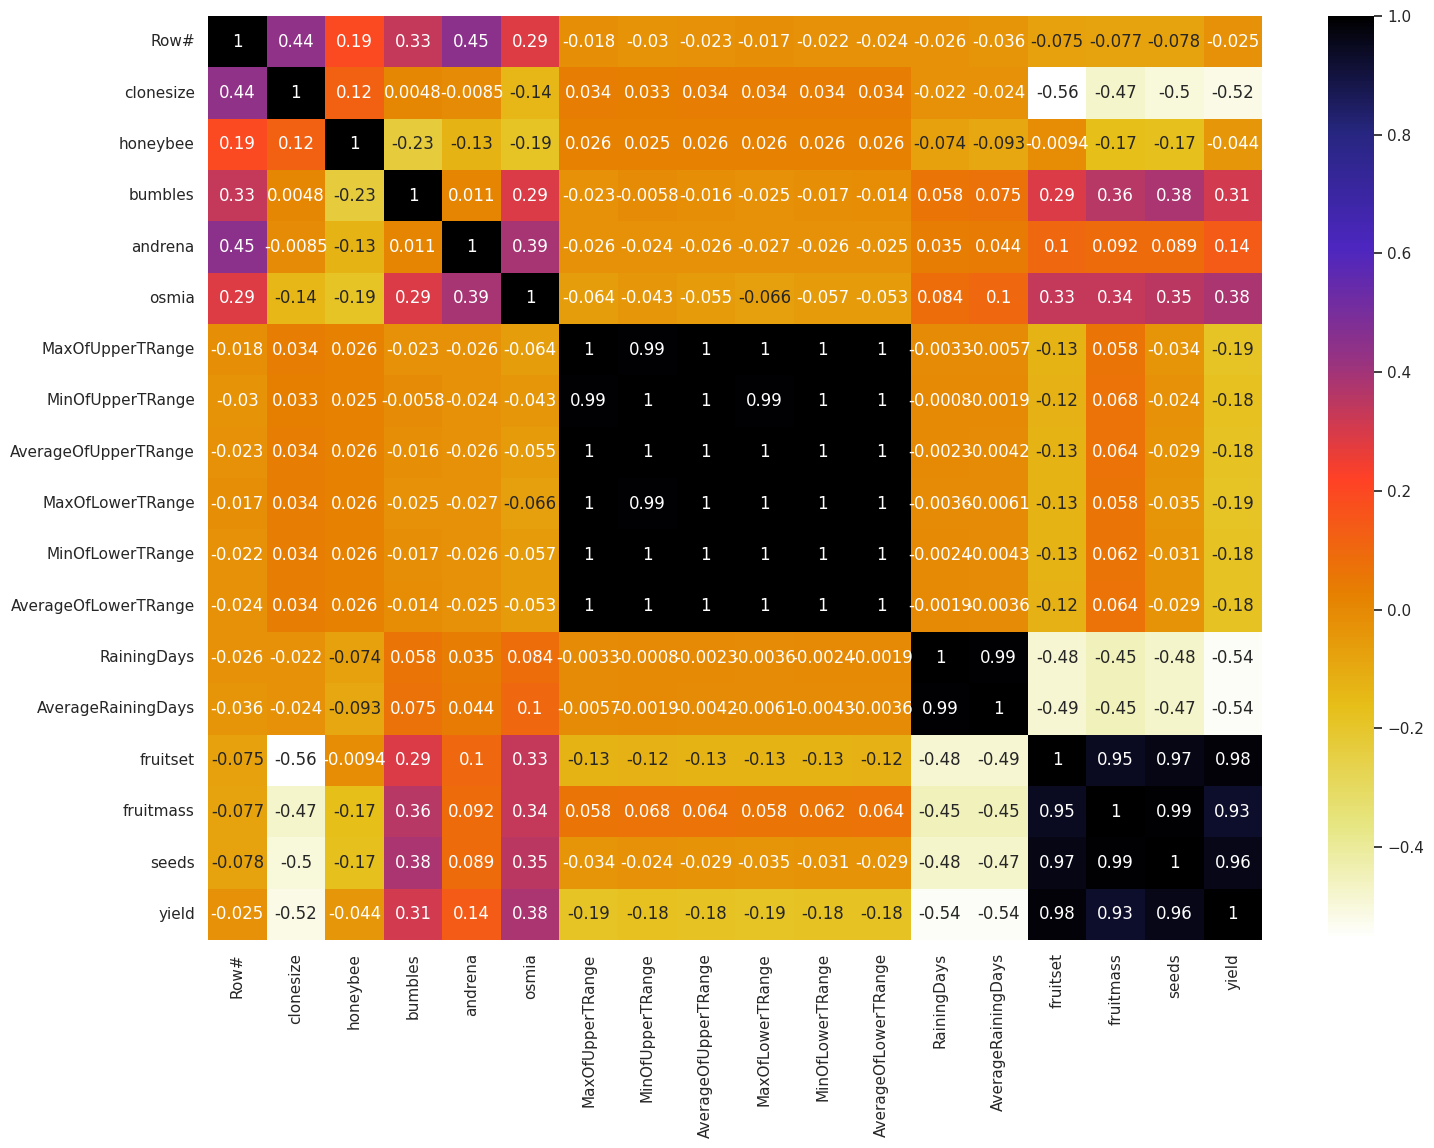

In [136]:
plt.figure(figsize=(17,12))
sns.set()
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.CMRmap_r)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Observations:</font></h3>
    
* Due to high correlation between features, some columns need to be dropped as they affect the output.
    
    correlated column: 'MaxOfUpperTRange', 'MinOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'RainingDays'

In [137]:
df.columns

Index(['Row#', 'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield'],
      dtype='object')

In [138]:
column=['Row#', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'RainingDays', 'honeybee', "fruitset", "fruitmass", "seeds"]
df = df.drop(columns = column)

In [139]:
df.head()

,clonesize,bumbles,andrena,osmia,AverageOfUpperTRange,AverageOfLowerTRange,AverageRainingDays,yield
0,37.5,0.25,0.25,0.25,71.9,50.8,0.26,3813.165795
1,37.5,0.25,0.25,0.25,71.9,50.8,0.10,4947.605663
2,37.5,0.25,0.25,0.25,79.0,55.9,0.26,3866.798965
3,37.5,0.25,0.25,0.25,79.0,55.9,0.10,4303.943030
4,37.5,0.25,0.25,0.25,71.9,50.8,0.39,3436.493543


In [147]:
X1 = df.drop(columns="yield")
y1 = df[["yield"]]
X1

,clonesize,bumbles,andrena,osmia,AverageOfUpperTRange,AverageOfLowerTRange,AverageRainingDays
0,37.5,0.250,0.250,0.250,71.9,50.8,0.26
1,37.5,0.250,0.250,0.250,71.9,50.8,0.10
2,37.5,0.250,0.250,0.250,79.0,55.9,0.26
3,37.5,0.250,0.250,0.250,79.0,55.9,0.10
4,37.5,0.250,0.250,0.250,71.9,50.8,0.39
...,...,...,...,...,...,...,...
772,10.0,0.117,0.409,0.058,71.9,50.8,0.06
773,40.0,0.117,0.409,0.058,71.9,50.8,0.06
774,20.0,0.117,0.409,0.058,71.9,50.8,0.39
775,20.0,0.117,0.409,0.058,65.6,45.3,0.06


In [152]:
Q1 = X1.quantile(0.25)
Q3 = X1.quantile(0.75)
IQR = Q3-Q1
IQR

clonesize               12.50
bumbles                  0.13
andrena                  0.25
osmia                    0.25
AverageOfUpperTRange     7.20
AverageOfLowerTRange     5.00
AverageRainingDays       0.29
dtype: float64

In [156]:
# Align each DataFrame or Series separately
df, Q1 = df.align(Q1, axis=1, copy=False)
df, Q3 = df.align(Q3, axis=1, copy=False)
df, IQR = df.align(IQR, axis=1, copy=False)

# Apply the condition after aligning
df_iqr = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
df_iqr.shape

(759, 8)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Observations:</font></h3>
    
* 777-759 = 18 rows we remove 18 row that are outlier

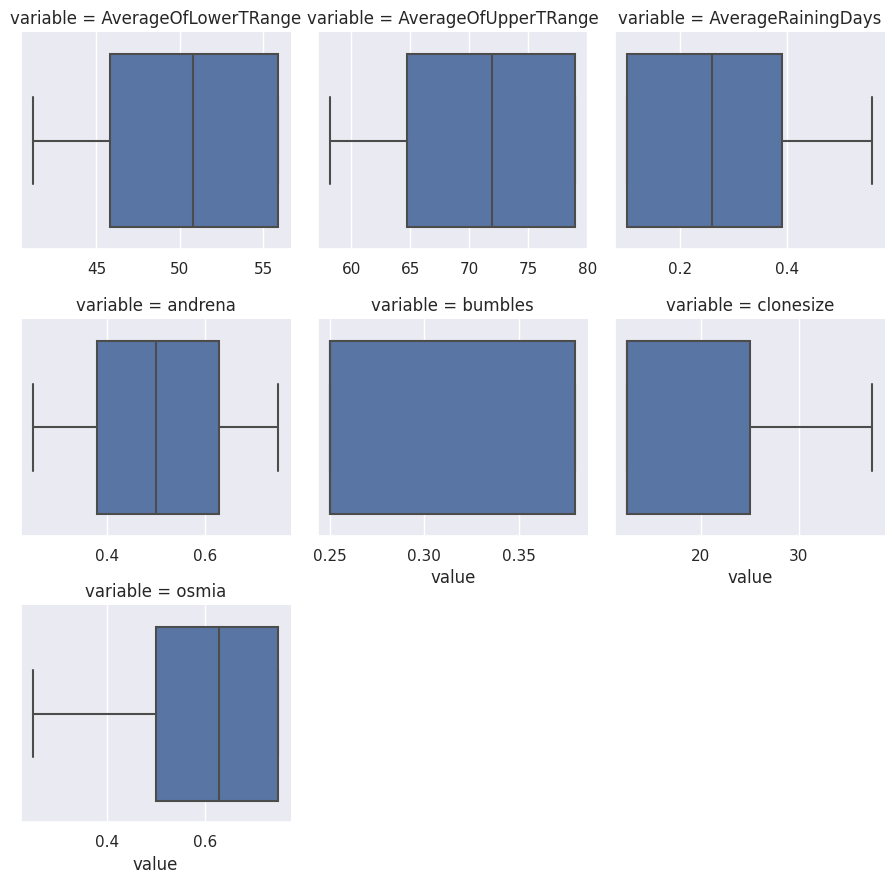

In [163]:
unpivot = pd.melt(df_iqr, df_iqr.describe().columns[-1], df_iqr.describe().columns[:-1])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.boxplot, "value")

plt.show()

In [164]:
z = np.abs(stats.zscore(df))
print(z)

     AverageOfLowerTRange  AverageOfUpperTRange  AverageRainingDays   andrena  \
0                0.403960              0.414096            0.350531  1.359549   
1                0.403960              0.414096            1.285279  1.359549   
2                1.346034              1.339534            0.350531  1.359549   
3                1.346034              1.339534            1.285279  1.359549   
4                0.403960              0.414096            0.408952  1.359549   
..                    ...                   ...                 ...       ...   
772              0.403960              0.414096            1.518966  0.371655   
773              0.403960              0.414096            1.518966  0.371655   
774              0.403960              0.414096            0.408952  0.371655   
775              0.612002              0.407067            1.518966  0.371655   
776              0.612002              0.407067            0.408952  0.371655   

      bumbles  clonesize   

In [165]:
df_zscore = df[(z<3).all(axis=1)]
df_zscore.shape

(767, 8)

In [166]:
df = df_zscore
df

,AverageOfLowerTRange,AverageOfUpperTRange,AverageRainingDays,andrena,bumbles,clonesize,osmia,yield
0,50.8,71.9,0.26,0.250,0.250,37.5,0.250,3813.165795
1,50.8,71.9,0.10,0.250,0.250,37.5,0.250,4947.605663
2,55.9,79.0,0.26,0.250,0.250,37.5,0.250,3866.798965
3,55.9,79.0,0.10,0.250,0.250,37.5,0.250,4303.943030
4,50.8,71.9,0.39,0.250,0.250,37.5,0.250,3436.493543
...,...,...,...,...,...,...,...,...
770,50.8,71.9,0.06,0.234,0.293,20.0,0.058,5449.421199
772,50.8,71.9,0.06,0.409,0.117,10.0,0.058,5333.873335
774,50.8,71.9,0.39,0.409,0.117,20.0,0.058,4203.027624
775,45.3,65.6,0.06,0.409,0.117,20.0,0.058,4166.299735


# <span style="font-family:cursive;text-align:center"> Feature Selection</span>

In [167]:
def select_features_corr_based(X_train, y_train, X_test, x="all"):
    if type(x) == str:
        fs_corr = SelectKBest(score_func=f_regression, k='all')
    else:
        fs_corr = SelectKBest(score_func=f_regression, k = x)
    fs_corr.fit(X_train, y_train)
    X_train_fs = fs_corr.transform(X_train)
    X_test_fs = fs_corr.transform(X_test)
    
    return X_train_fs, X_test_fs, fs_corr

def select_features_infogain_based(X_train, y_train, X_test, x="all"):
    if type(x) == str:
        fs_info = SelectKBest(score_func=mutual_info_regression, k='all')
    else:
        fs_info = SelectKBest(score_func=mutual_info_regression, k=x)
    fs_info.fit(X_train, y_train)
    X_train_fs = fs_info.transform(X_train)
    X_test_fs = fs_info.transform(X_test)
    
    return X_train_fs, X_test_fs, fs_info

In [169]:
X = df.drop(columns = "yield", axis=1)
y = df["yield"]
X

,AverageOfLowerTRange,AverageOfUpperTRange,AverageRainingDays,andrena,bumbles,clonesize,osmia
0,50.8,71.9,0.26,0.250,0.250,37.5,0.250
1,50.8,71.9,0.10,0.250,0.250,37.5,0.250
2,55.9,79.0,0.26,0.250,0.250,37.5,0.250
3,55.9,79.0,0.10,0.250,0.250,37.5,0.250
4,50.8,71.9,0.39,0.250,0.250,37.5,0.250
...,...,...,...,...,...,...,...
770,50.8,71.9,0.06,0.234,0.293,20.0,0.058
772,50.8,71.9,0.06,0.409,0.117,10.0,0.058
774,50.8,71.9,0.39,0.409,0.117,20.0,0.058
775,45.3,65.6,0.06,0.409,0.117,20.0,0.058


In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=47)

X_train_fs_corr, X_test_fs_corr, fs_corr = select_features_corr_based(X_train, y_train, X_test)
X_train_fs_info, X_test_fs_info, fs_info = select_features_infogain_based(X_train, y_train, X_test)

Feature AverageOfLowerTRange: 21.106241
Feature AverageOfUpperTRange: 21.121118
Feature AverageRainingDays: 233.475561
Feature andrena: 13.065596
Feature bumbles: 65.961070
Feature clonesize: 181.320267
Feature osmia: 87.144321


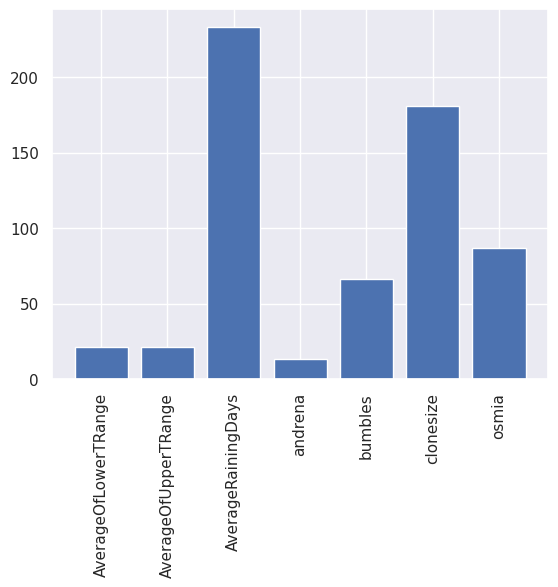

Feature AverageOfLowerTRange: 0.100500
Feature AverageOfUpperTRange: 0.100532
Feature AverageRainingDays: 0.206256
Feature andrena: 0.055131
Feature bumbles: 0.080871
Feature clonesize: 0.144397
Feature osmia: 0.087256


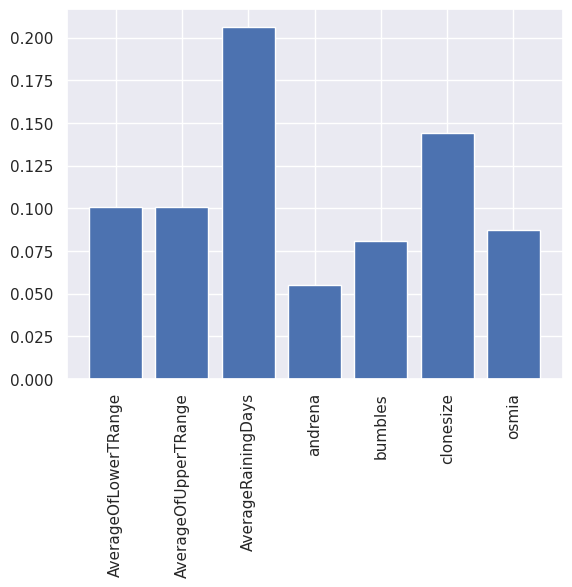

In [178]:
def fs_score_plot(fs_func):
    
    for i in range(len(fs_func.get_feature_names_out())):
        print('Feature %s: %f' % (fs_func.get_feature_names_out()[i], fs_func.scores_[i]))
    # plot the scores
    plt.bar(fs_func.get_feature_names_out(), fs_func.scores_)
    plt.xticks(rotation=90)
    plt.show()
    
fs_score_plot(fs_corr)
fs_score_plot(fs_info)

In [179]:
X = df.drop(["yield"], axis=1)
y = df['yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

X_train_fs, X_test_fs, fs_info = select_features_infogain_based(X_train, y_train, X_test, x=7)

In [180]:
models={
    "Linear Regression":LinearRegression(),
    "XGB Regressor":XGBRegressor(),
    "Decision Tree Regressor":DecisionTreeRegressor(),
    "Random Forest Regressor":RandomForestRegressor()
}

In [183]:
for key, model in models.items():
    model.fit(X_train_fs, y_train)
    yhat = model.predict(X_test_fs)
    
    mae = mean_absolute_error(y_test, yhat)
    mse = mean_squared_error(y_test, yhat)
    rmse = np.sqrt(mse)
    rsq = r2_score(y_test, yhat)
    
    print(key)
    print('MAE: %.3f' % mae)
    print('MSE: %.3f' % mse)
    print('RMSE: %.3f' % rmse)
    print('R-Square: %.3f' % rsq)
    print("______________\n")

Linear Regression
MAE: 498.588
MSE: 362441.786
RMSE: 602.031
R-Square: 0.804
______________

XGB Regressor
MAE: 178.562
MSE: 62583.025
RMSE: 250.166
R-Square: 0.966
______________

Decision Tree Regressor
MAE: 262.590
MSE: 125367.157
RMSE: 354.072
R-Square: 0.932
______________

Random Forest Regressor
MAE: 214.514
MSE: 75846.567
RMSE: 275.403
R-Square: 0.959
______________

